# Implementation of Unet++ Architecture and assessment on COVID-19 using Chest-Xray segmentation analysis

<!--![qata](https://181fde73e78a.ngrok.io/static/imgs/banner.png)-->
![qata](https://c1df151ac00c.ngrok.io/static/imgs/banner.png)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Importing dataset

*   The dataset is taken from Kaggle repository **[QaTa-COV19](https://www.kaggle.com/aysendegerli/qatacov19-dataset)** 

In [ ]:
import os
from google.colab import drive

# Mount the google drive
drive.mount('/content/gdrive')

# Setting the environment path
os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/My Drive/Kaggle"

!kaggle datasets download -d aysendegerli/qatacov19-dataset

Mounted at /content/gdrive
100% 4.79G/4.79G [01:47<00:00, 70.7MB/s]
100% 4.79G/4.79G [01:47<00:00, 47.9MB/s]


In [ ]:
#unzipping the zip files and deleting the zip files
!unzip -q \*.zip  && rm *.zip

## EDA:

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt

path_chestXrayImages = "/content/QaTa-COV19/QaTa-COV19/Images"
path_groundTruthImages = "/content/QaTa-COV19/QaTa-COV19/Ground-truths"

chest_ids = next(os.walk(path_chestXrayImages))[2] # list of names all images in the given path
print("No. of chest images = ", len(chest_ids))

ground_truths_ids = next(os.walk(path_groundTruthImages))[2] # list of names all images in the given path
print("No. of ground truth images = ", len(ground_truths_ids))

im = Image.open(os.path.join(path_chestXrayImages,chest_ids[0]))
width, height = im.size
print("Size of COVID chest Image:({},{})".format(width,height))

im = Image.open(os.path.join(path_groundTruthImages,ground_truths_ids[0]))
width, height = im.size
print("Size of Ground truth Image:({},{})".format(width,height))

plt.bar(['chest_ids','ground_truths_ids'],[len(chest_ids),len(ground_truths_ids)])

NameError: ignored

No. of chest images =  4603
No. of ground truth images =  2961
Size of COVID chest Image:(224,224)
Size of Ground truth Image:(224,224)


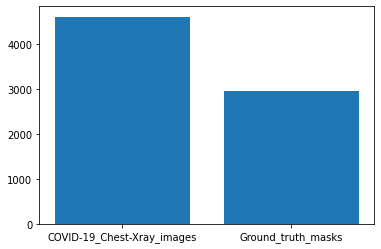

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt
import os

path_chestXrayImages = "/content/drive/MyDrive/CS6400 - Covid Detection/QaTa-COV19/QaTa-COV19/Images"
path_groundTruthImages = "/content/drive/MyDrive/CS6400 - Covid Detection/QaTa-COV19/QaTa-COV19/Ground-truths"

chest_ids_2 = next(os.walk(path_chestXrayImages))[2] # list of names all images in the given path
print("No. of chest images = ", len(chest_ids_2))

ground_truths_ids_2 = next(os.walk(path_groundTruthImages))[2] # list of names all images in the given path
print("No. of ground truth images = ", len(ground_truths_ids_2))

im = Image.open(os.path.join(path_chestXrayImages,chest_ids_2[0]))
width, height = im.size
print("Size of COVID chest Image:({},{})".format(width,height))

im = Image.open(os.path.join(path_groundTruthImages,ground_truths_ids_2[0]))
width, height = im.size
print("Size of Ground truth Image:({},{})".format(width,height))

plt.bar(['COVID-19_Chest-Xray_images','Ground_truth_masks'],[len(chest_ids_2),len(ground_truths_ids_2)])
plt.savefig('Dataset_info.png')


# Removal of duplicates
for ids in ground_truths_ids_2:
  if ids[5:] not in chest_ids_2:
    ground_truths_ids_2.remove(ids)

In [ ]:
# Splitting the data to training to train and test data
from sklearn.model_selection import train_test_split
train_id, valid_id = train_test_split(ground_truths_ids_2, test_size=0.2, random_state=42)
print(f'Dimensions of X_train: {len(train_id)}')
print(f'Dimensions of X_valid: {len(valid_id)}')

Dimensions of X_train: 2360
Dimensions of X_valid: 591


## Setting up the environment

In [ ]:
# Installing albumetations library and segmentation models library
!pip install -U -q git+https://github.com/albumentations-team/albumentations
!pip install -U -q git+https://github.com/qubvel/segmentation_models.pytorch

     |████████████████████████████████| 37.1 MB 75 kB/s 
     |████████████████████████████████| 58 kB 3.0 MB/s 
     |████████████████████████████████| 376 kB 10.4 MB/s 


In [ ]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

import numpy as np
import cv2
import matplotlib.pyplot as plt

from torch.utils.data import DataLoader, Dataset as BaseDataset

# helper function for data visualization
def visualize(**images):
  
    """Plot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image,cmap = 'seismic', interpolation = 'bilinear')
    plt.show()

class Dataset(BaseDataset):
    """COVID-19 Dataset. Read images, apply augmentation and preprocessing transformations.
    
    Args:
        image_ids (str) : ids for the each COVID-19 images
        images_dir (str): path to images folder
        masks_dir (str): path to segmentation masks folder
        augmentation (albumentations.Compose): data transfromation pipeline 
            (e.g. flip, scale, etc.)
        preprocessing (albumentations.Compose): data preprocessing 
            (e.g. normalization, shape manipulation, etc.)
    
    """
    
    def __init__(
            self,
            image_ids, 
            images_dir, 
            masks_dir,
            augmentation=None, 
            preprocessing=None,
    ):
        
        self.ids = image_ids
        self.images_fps = [os.path.join(images_dir, image_id[5:]) for image_id in self.ids]
        self.masks_fps = [os.path.join(masks_dir, image_id) for image_id in self.ids] if masks_dir != None else None
        
        self.augmentation = augmentation
        self.preprocessing = preprocessing
    
    def __getitem__(self, i):
        
        # read data
        image = cv2.imread(self.images_fps[i])
        image = cv2.resize(image,(224,224))
        
        #image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        if self.masks_fps:
          mask = cv2.imread(self.masks_fps[i],0)/255.
          masks = [(mask == v) for v in [1]]
          mask = np.stack(masks, axis=-1).astype('float')
        else:
          mask = np.zeros((224,224,1)).astype('float')
          
        
        # apply augmentations
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
        
        # apply preprocessing
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
            
        return image, mask
        
    def __len__(self):
        return len(self.ids)  

(224, 224, 1)


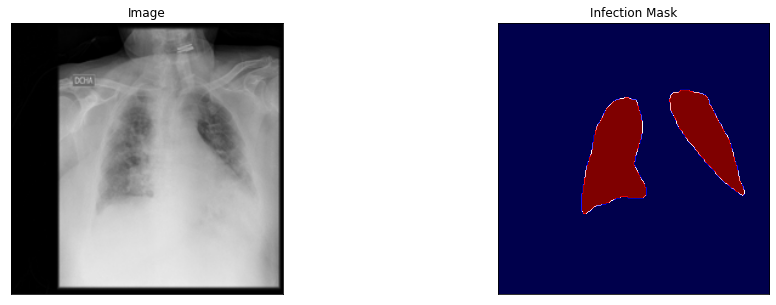

In [ ]:
# Lets look at data we have

dataset = Dataset(train_id,path_chestXrayImages, path_groundTruthImages)

image, mask = dataset[3] # get some sample
visualize(
    image=image, 
    infection_mask=mask.squeeze(),
)

In [ ]:
import albumentations as albu
'''
Note on Albumentation:

Albumentation is a faster and flexible library for image augmentation process.
It outperforms any other augmentation libraries in Computer vision world 
[https://www.researchgate.net/publication/327742409_Albumentations_fast_and_flexible_image_augmentations] 

Here we perform specfic set of augmentation tasks which on relevant to chest Xrays
          Training set augmentation:
            1. Geometric Transformation:
              Affine Transformation:
                Rotation: Image rotation kept at 20degrees with probability of 0.75
                Scaling: Image could be scaled with a maximum limit kept as 1.2
                Shifting: Image shifting is done with a limit of 0.1
            1. Lighting Tranformations : 
              CLAHE (Contrast Limited Adaptive Histogram Equalization)


            2. Padding (Optional):
              Padding is provided to adjust the model to perceive the lung's image

'''
def get_training_augmentation():
    
    train_transform = [

                    
        albu.Affine(scale = 1.2, translate_percent=0.1, rotate=(-20,20), p=0.75),
        albu.PadIfNeeded(256, 256,  border_mode=0, p = 1),

        albu.OneOf(
            [
                albu.RandomBrightnessContrast(brightness_limit = (-0.3,0.3),contrast_limit = 0.3,p=1),
                albu.RandomGamma(gamma_limit = (60,120),p=1)
            ],
            p=0.75,
        ),

        albu.OneOf(
            [
                albu.Sharpen(p=1),
                albu.Blur(blur_limit=3, p=1),
            ],
            p=0.75,
        )
    ]
    # Additional transforms snippet:
    # albu.ShiftScaleRotate(scale_limit=0.1, rotate_limit=20, shift_limit=0.1, p=0.75, border_mode=0),
    return albu.Compose(train_transform)


def get_validation_augmentation():
    
    test_transform = [
        albu.PadIfNeeded(256, 256,  border_mode=0, p = 1)
    ]
    return albu.Compose(test_transform)


def to_tensor(x, **kwargs):
  
    return x.transpose(2, 0, 1).astype('float32')


def get_preprocessing(preprocessing_fn):
    """Construct preprocessing transform
    
    Args:
        preprocessing_fn (callable): data normalization function 
            (can be specific for each pretrained neural network)
    Return:
        transform: albumentations.Compose
    
    """
    
    _transform = [
        albu.Lambda(image=preprocessing_fn),
        albu.Lambda(image=to_tensor, mask=to_tensor),
    ]
    return albu.Compose(_transform)

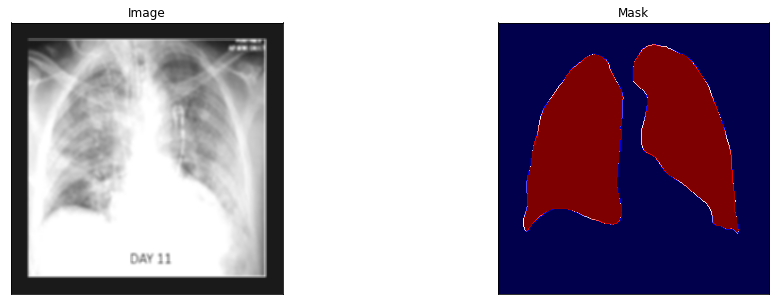

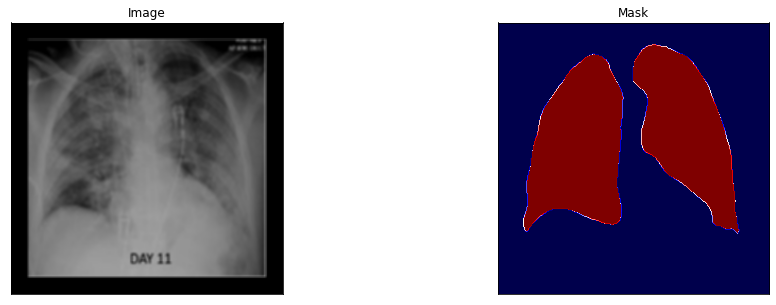

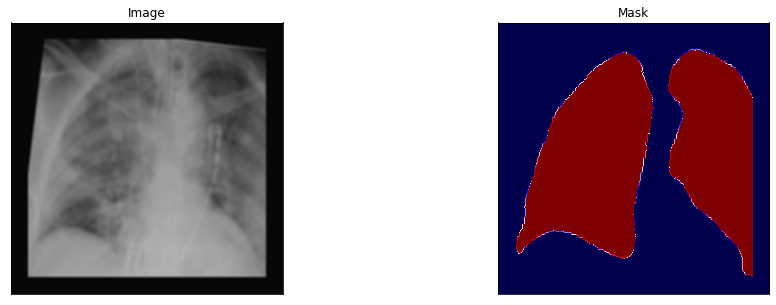

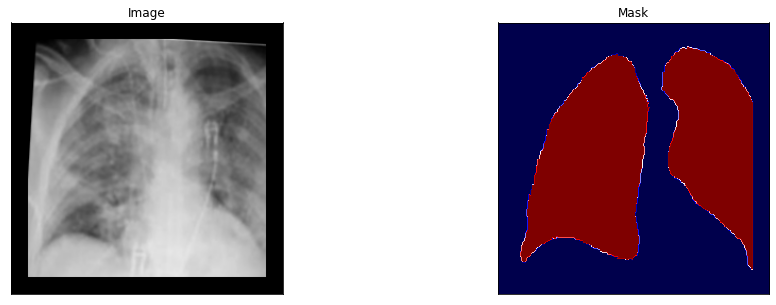

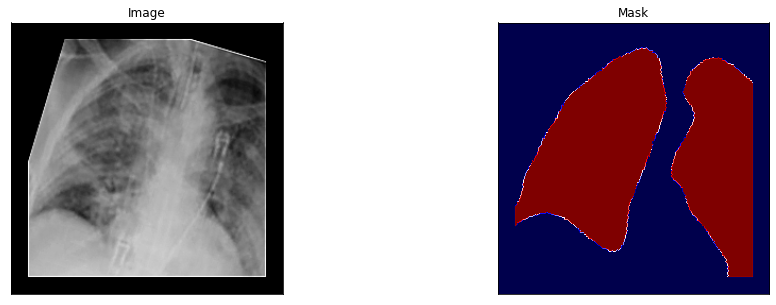

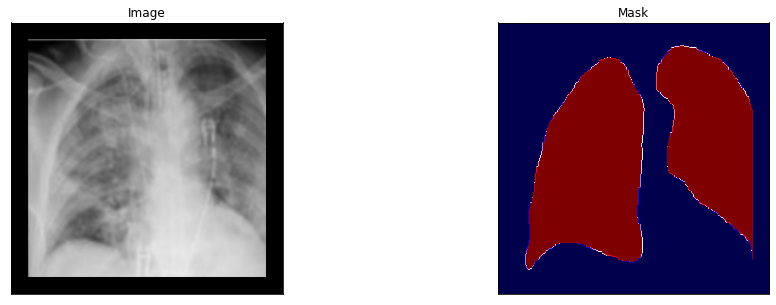

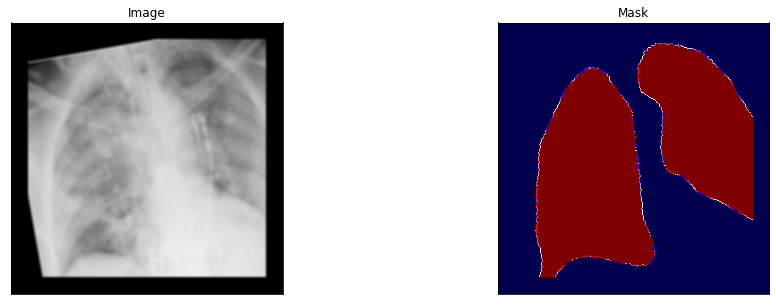

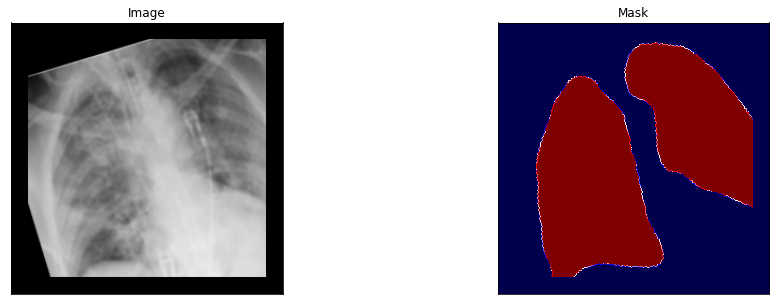

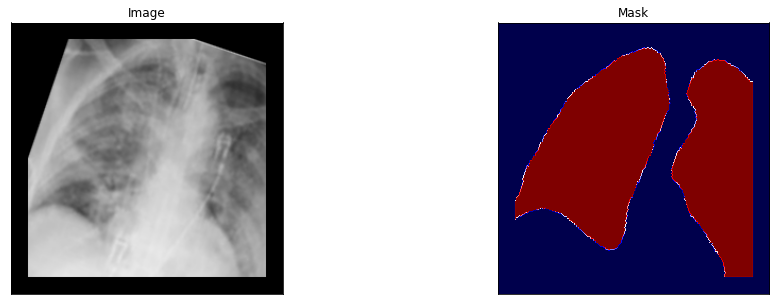

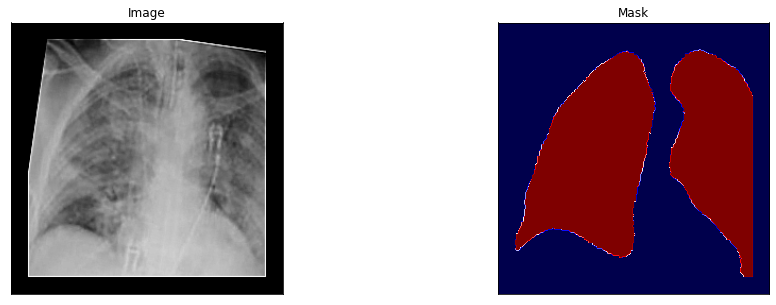

In [ ]:
#### Visualize resulted augmented images and masks

augmented_dataset = Dataset(
    train_id,path_chestXrayImages, path_groundTruthImages, 
    augmentation=get_training_augmentation(),
)

# same image with different random transforms
for i in range(10):
    image, mask = augmented_dataset[1512]
    visualize(image=image, mask=mask.squeeze())

In [ ]:
import torch
import numpy as np
import segmentation_models_pytorch as smp

ENCODER = 'resnext50_32x4d'
ENCODER_WEIGHTS = 'imagenet'

ACTIVATION = 'sigmoid' 
DEVICE = 'cuda'

# create segmentation model with pretrained encoder
model = smp.UnetPlusPlus(
    encoder_name=ENCODER, 
    encoder_weights=ENCODER_WEIGHTS, 
    classes=1, 
    activation=ACTIVATION,
)

preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)

Downloading: "https://download.pytorch.org/models/resnext50_32x4d-7cdf4587.pth" to /root/.cache/torch/hub/checkpoints/resnext50_32x4d-7cdf4587.pth


  0%|          | 0.00/95.8M [00:00<?, ?B/s]

In [ ]:
train_dataset = Dataset(
    train_id,path_chestXrayImages, path_groundTruthImages,
    augmentation=get_training_augmentation(), 
    preprocessing=get_preprocessing(preprocessing_fn),
)

valid_dataset = Dataset(
    valid_id,path_chestXrayImages, path_groundTruthImages,
    augmentation=get_validation_augmentation(), 
    preprocessing=get_preprocessing(preprocessing_fn),
)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=24)
valid_loader = DataLoader(valid_dataset, batch_size=2, shuffle=False, num_workers=8)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 24 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
x, y = next(iter(train_loader))

print(f'x = shape: {x.shape}; type: {x.dtype}')
print(f'x = min: {x.min()}; max: {x.max()}')
print(f'y = shape: {y.shape}; class: {y.unique()}; type: {y.dtype}')

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 24 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


x = shape: torch.Size([16, 3, 256, 256]); type: torch.float32
x = min: -2.1179039478302; max: 2.640000104904175
y = shape: torch.Size([16, 1, 256, 256]); class: tensor([0., 1.]); type: torch.float32


In [ ]:
from torchsummary import summary
#summary = summary(model.to(DEVICE), (3, 256, 256))

In [ ]:
# Dice/F1 score - https://en.wikipedia.org/wiki/S%C3%B8rensen%E2%80%93Dice_coefficient
# IoU/Jaccard score - https://en.wikipedia.org/wiki/Jaccard_index

#loss = smp.losses.DiceLoss('binary')
#loss = smp.utils.losses.TverskyLoss() 
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.utils.base import Loss
from segmentation_models_pytorch.losses import  FocalLoss
class FocalLoss(FocalLoss,Loss):
  pass
loss = smp.utils.losses.DiceLoss() +  FocalLoss('binary')

metrics = [
    smp.utils.metrics.IoU(eps = 1e-08,threshold=0.5),
    smp.utils.metrics.Fscore()
]

learning_rate = 0.00001

optimizer = torch.optim.Adam([ 
    dict(params=model.parameters(), lr=learning_rate),
])

In [ ]:
# create epoch runners 
# it is a simple loop of iterating over dataloader`s samples
train_epoch = smp.utils.train.TrainEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    optimizer=optimizer,
    device=DEVICE,
    verbose=True,
)

valid_epoch = smp.utils.train.ValidEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    device=DEVICE,
    verbose=True,
)

In [ ]:
# train model for 40 epochs

max_score = 0

for i in range(0, 50):
    
    print('\nEpoch: {}'.format(i))
    train_logs = train_epoch.run(train_loader)
    valid_logs = valid_epoch.run(valid_loader)
    
    # do something (save model, change lr, etc.)
    if max_score < valid_logs['iou_score']:
        max_score = valid_logs['iou_score']
        torch.save(model, './best_model.pth')
        print('Model saved!')
        
    if i == 35:
        optimizer.param_groups[0]['lr'] = 1e-5
        print('Decrease decoder learning rate to 1e-5!')


Epoch: 0
train:   0%|          | 0/148 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 24 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


valid:   0%|          | 0/296 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


valid: 100%|██████████| 296/296 [01:06<00:00,  4.42it/s, dice_loss + focal_loss - 0.7626, iou_score - 0.5944, fscore - 0.7312]
Model saved!

Epoch: 1
valid: 100%|██████████| 296/296 [00:15<00:00, 19.45it/s, dice_loss + focal_loss - 0.698, iou_score - 0.6539, fscore - 0.7773]
Model saved!

Epoch: 2
valid: 100%|██████████| 296/296 [00:15<00:00, 19.29it/s, dice_loss + focal_loss - 0.6761, iou_score - 0.6785, fscore - 0.7951]
Model saved!

Epoch: 3
valid: 100%|██████████| 296/296 [00:15<00:00, 19.52it/s, dice_loss + focal_loss - 0.6379, iou_score - 0.6818, fscore - 0.7987]
Model saved!

Epoch: 4
valid: 100%|██████████| 296/296 [00:15<00:00, 19.38it/s, dice_loss + focal_loss - 0.6052, iou_score - 0.6826, fscore - 0.7983]
Model saved!

Epoch: 5
valid: 100%|██████████| 296/296 [00:15<00:00, 19.43it/s, dice_loss + focal_loss - 0.5951, iou_score - 0.7008, fscore - 0.8106]
Model saved!

Epoch: 6
valid: 100%|██████████| 296/296 [00:15<00:00, 19.26it/s, dice_loss + focal_loss - 0.5688, iou_score -

In [ ]:
# train model for 40 epochs

max_score = 0
train_logs = []
valid_logs = []
for i in range(0, 50):
    
    print('\nEpoch: {}'.format(i))
    train_logs.append(train_epoch.run(train_loader))
    valid_logs.append(valid_epoch.run(valid_loader))
    
    # do something (save model, change lr, etc.)
    if max_score < valid_logs[i]['iou_score']:
        max_score = valid_logs[i]['iou_score']
        torch.save(model, './best_model.pth')
        print('Model saved!')
        
    if i == 35:
        optimizer.param_groups[0]['lr'] = 1e-5
        print('Decrease decoder learning rate to 1e-5!')


Epoch: 0
train:   0%|          | 0/148 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 24 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


valid:   0%|          | 0/296 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


valid: 100%|██████████| 296/296 [00:22<00:00, 13.12it/s, dice_loss + focal_loss - 0.8843, iou_score - 0.5182, fscore - 0.6687]
Model saved!

Epoch: 1
valid: 100%|██████████| 296/296 [00:15<00:00, 18.85it/s, dice_loss + focal_loss - 0.8169, iou_score - 0.6027, fscore - 0.7383]
Model saved!

Epoch: 2
valid: 100%|██████████| 296/296 [00:15<00:00, 18.85it/s, dice_loss + focal_loss - 0.7935, iou_score - 0.6128, fscore - 0.747]
Model saved!

Epoch: 3
valid: 100%|██████████| 296/296 [00:15<00:00, 18.82it/s, dice_loss + focal_loss - 0.7674, iou_score - 0.6448, fscore - 0.7718]
Model saved!

Epoch: 4
valid: 100%|██████████| 296/296 [00:15<00:00, 18.83it/s, dice_loss + focal_loss - 0.7436, iou_score - 0.6746, fscore - 0.7939]
Model saved!

Epoch: 5
valid: 100%|██████████| 296/296 [00:15<00:00, 18.67it/s, dice_loss + focal_loss - 0.7248, iou_score - 0.6662, fscore - 0.7871]

Epoch: 6
valid: 100%|██████████| 296/296 [00:15<00:00, 18.80it/s, dice_loss + focal_loss - 0.7084, iou_score - 0.6801, fsco

In [ ]:
best_model = torch.load('./best_model.pth')

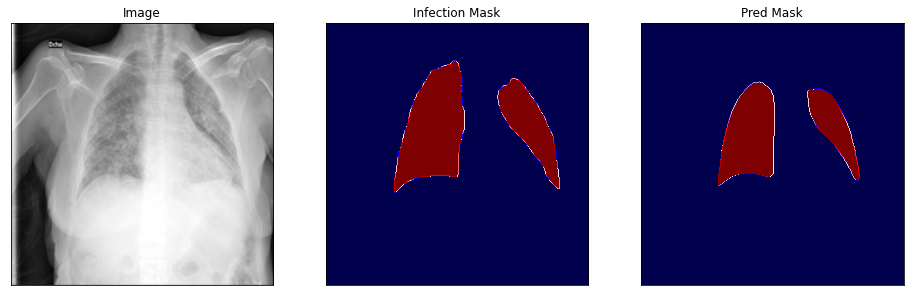

In [ ]:
test = Dataset(valid_id,path_chestXrayImages, path_groundTruthImages, augmentation=get_validation_augmentation(), 
    preprocessing=get_preprocessing(preprocessing_fn))
test_vis = Dataset(valid_id,path_chestXrayImages, path_groundTruthImages)

k = 210
image, mask = test[k] # get some sample
image_vis, mask_vis = test_vis[k]

x_tensor = torch.from_numpy(image).to(DEVICE).unsqueeze(0)
pr_mask = best_model.predict(x_tensor)
pr_mask = (pr_mask.squeeze().cpu().numpy().round())

visualize(
    image=image_vis, 
    infection_mask=mask_vis.squeeze(),
    pred_mask = pr_mask
)


In [ ]:
def plot_training(training_losses,
                  validation_losses,
                  learning_rate,
                  gaussian=True,
                  sigma=2,
                  figsize=(8, 6)
                  ):
    """
    Returns a loss plot with training loss, validation loss and learning rate.
    """

    import matplotlib.pyplot as plt
    from matplotlib import gridspec
    from scipy.ndimage import gaussian_filter

    list_len = len(training_losses)
    x_range = list(range(1, list_len + 1))  # number of x values

    fig = plt.figure(figsize=figsize)
    grid = gridspec.GridSpec(ncols=2, nrows=1, figure=fig)

    subfig1 = fig.add_subplot(grid[0, 0])
    subfig2 = fig.add_subplot(grid[0, 1])

    subfigures = fig.get_axes()

    for i, subfig in enumerate(subfigures, start=1):
        subfig.spines['top'].set_visible(False)
        subfig.spines['right'].set_visible(False)

    if gaussian:
        training_losses_gauss = gaussian_filter(training_losses, sigma=sigma)
        validation_losses_gauss = gaussian_filter(validation_losses, sigma=sigma)

        linestyle_original = '.'
        color_original_train = 'lightcoral'
        color_original_valid = 'lightgreen'
        color_smooth_train = 'red'
        color_smooth_valid = 'green'
        alpha = 0.25
    else:
        linestyle_original = '-'
        color_original_train = 'red'
        color_original_valid = 'green'
        alpha = 1.0

    # Subfig 1
    subfig1.plot(x_range, training_losses, linestyle_original, color=color_original_train, label='Training',
                 alpha=alpha)
    subfig1.plot(x_range, validation_losses, linestyle_original, color=color_original_valid, label='Validation',
                 alpha=alpha)
    if gaussian:
        subfig1.plot(x_range, training_losses_gauss, '-', color=color_smooth_train, label='Training', alpha=0.75)
        subfig1.plot(x_range, validation_losses_gauss, '-', color=color_smooth_valid, label='Validation', alpha=0.75)
    subfig1.title.set_text('Training & validation loss')
    subfig1.set_xlabel('Epoch')
    subfig1.set_ylabel('Loss')

    subfig1.legend(loc='upper right')

    # Subfig 2
    subfig2.plot(x_range, learning_rate, color='black')
    subfig2.title.set_text('Learning rate')
    subfig2.set_xlabel('Epoch')
    subfig2.set_ylabel('LR')

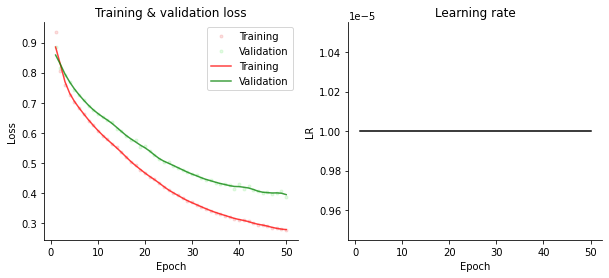

In [ ]:
training_loss_logs = pd.DataFrame(train_logs)['dice_loss + focal_loss'].to_numpy()
validation_loss_logs = pd.DataFrame(valid_logs)['dice_loss + focal_loss'].to_numpy()
lr_logs = np.array([learning_rate]*len(training_loss_logs))
fig_1 = plot_training(training_loss_logs,validation_loss_logs,lr_logs,sigma=1,figsize=(10,4),gaussian=True)

In [ ]:
def plot_training_2(training_score,
                  validation_score,
                  training_score_2,
                  validation_score_2,
                  gaussian=True,
                  sigma=2,
                  figsize=(8, 6)
                  ):
    """
    Returns a loss plot with training loss, validation loss and learning rate.
    """

    import matplotlib.pyplot as plt
    from matplotlib import gridspec
    from scipy.ndimage import gaussian_filter

    list_len = len(training_score)
    x_range = list(range(1, list_len + 1))  # number of x values

    fig = plt.figure(figsize=figsize)
    grid = gridspec.GridSpec(ncols=2, nrows=1, figure=fig)

    subfig1 = fig.add_subplot(grid[0, 0])
    subfig2 = fig.add_subplot(grid[0, 1])

    subfigures = fig.get_axes()

    for i, subfig in enumerate(subfigures, start=1):
        subfig.spines['top'].set_visible(False)
        subfig.spines['right'].set_visible(False)

    if gaussian:
        training_score_gauss = gaussian_filter(training_score, sigma=sigma)
        validation_score_gauss = gaussian_filter(validation_score, sigma=sigma)

        linestyle_original = '.'
        color_original_train = 'lightcoral'
        color_original_valid = 'lightgreen'
        color_smooth_train = 'red'
        color_smooth_valid = 'green'
        alpha = 0.25
    else:
        linestyle_original = '-'
        color_original_train = 'red'
        color_original_valid = 'green'
        alpha = 1.0

    # Subfig 1
    subfig1.plot(x_range, training_score, linestyle_original, color=color_original_train, label='Training',
                 alpha=alpha)
    subfig1.plot(x_range, validation_score, linestyle_original, color=color_original_valid, label='Validation',
                 alpha=alpha)
    if gaussian:
        subfig1.plot(x_range, training_score_gauss, '-', color=color_smooth_train, label='Training', alpha=0.75)
        subfig1.plot(x_range, validation_score_gauss, '-', color=color_smooth_valid, label='Validation', alpha=0.75)
    subfig1.title.set_text('Training & validation IoU score')
    subfig1.set_xlabel('Epoch')
    subfig1.set_ylabel('Loss')

    subfig1.legend(loc='upper right')

    # Subfig 2
    if gaussian:
        training_score_gauss_2 = gaussian_filter(training_score_2, sigma=sigma)
        validation_score_gauss_2 = gaussian_filter(validation_score_2, sigma=sigma)
    subfig2.plot(x_range, training_score_2, linestyle_original, color=color_original_train, label='Training',
                 alpha=alpha)
    subfig2.plot(x_range, validation_score_2, linestyle_original, color=color_original_valid, label='Validation',
                 alpha=alpha)
    if gaussian:
        subfig2.plot(x_range, training_score_gauss_2, '-', color=color_smooth_train, label='Training', alpha=0.75)
        subfig2.plot(x_range, validation_score_gauss_2, '-', color=color_smooth_valid, label='Validation', alpha=0.75)
    subfig2.title.set_text('Training & validation F-score')
    subfig2.set_xlabel('Epoch')
    subfig2.set_ylabel('Loss')

    subfig2.legend(loc='upper right')

    return fig

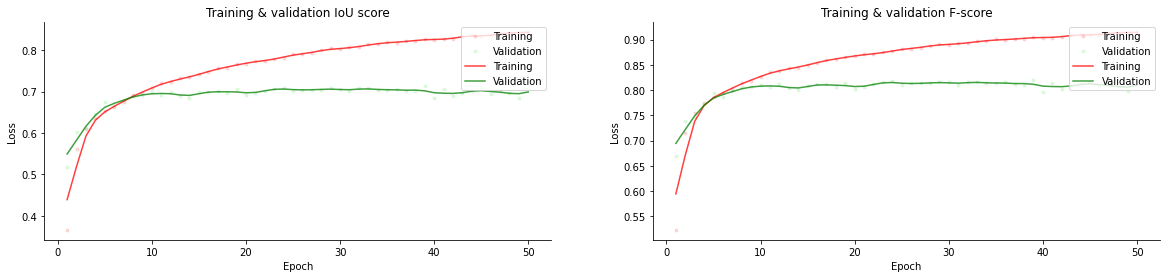

In [ ]:
training_iou_score_logs = pd.DataFrame(train_logs)['iou_score'].to_numpy()
validation_iou_score_logs = pd.DataFrame(valid_logs)['iou_score'].to_numpy()
training_fscore_logs = pd.DataFrame(train_logs)['fscore'].to_numpy()
validation_fscore_logs = pd.DataFrame(valid_logs)['fscore'].to_numpy()
fig_1 = plot_training_2(training_iou_score_logs,validation_iou_score_logs,training_fscore_logs,validation_fscore_logs,sigma=1,figsize=(20,4),gaussian=True)

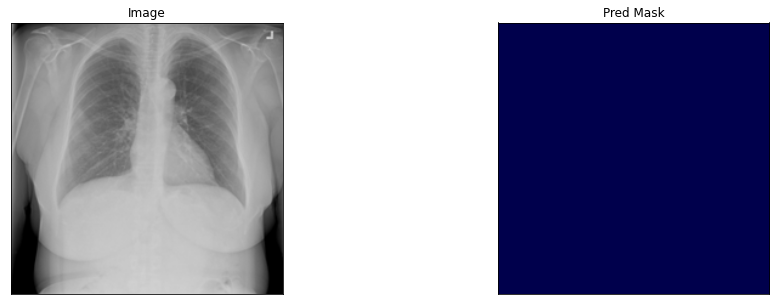

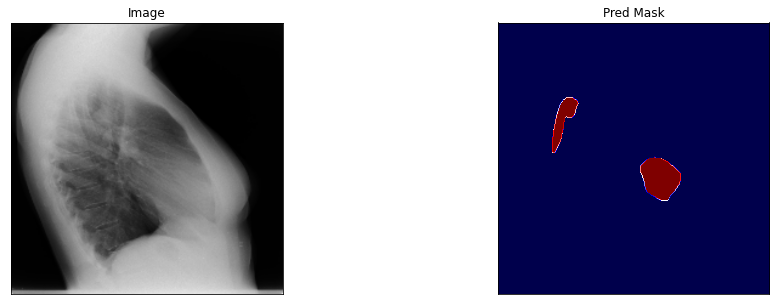

In [ ]:
blank_mask = np.zeros((224,224,1)).astype('float')

normal_chest_img_path = '/content/drive/MyDrive/CS6400 - Covid Detection/QaTa-COV19/QaTa-COV19/Normal'
normal_chest_ids = next(os.walk(normal_chest_img_path))[2]
normal_chest_ids = ["_____"+ids for ids in normal_chest_ids]

# Normal chest Prediction
test = Dataset(normal_chest_ids,normal_chest_img_path,None, augmentation=get_validation_augmentation(), 
    preprocessing=get_preprocessing(preprocessing_fn))

test_vis = Dataset(normal_chest_ids,normal_chest_img_path,None)

k = 15
image, mask = test[k] # get some sample
image_vis, mask_vis = test_vis[k]

x_tensor = torch.from_numpy(image).to(DEVICE).unsqueeze(0)
pr_mask = best_model.predict(x_tensor)
pr_mask = (pr_mask.squeeze().cpu().numpy().round())

visualize(
    image=image_vis,
    pred_mask = pr_mask
)

# COVID-19 ChestXRay prediction:
test_covid_images = chest_ids_2
for ids in ground_truths_ids_2:
  if ids[5:] in test_covid_images:
    test_covid_images.remove(ids[5:])
test_covid_images = ["_____"+ids for ids in test_covid_images]
test = Dataset(test_covid_images,path_chestXrayImages,None, augmentation=get_validation_augmentation(), 
    preprocessing=get_preprocessing(preprocessing_fn))

test_vis = Dataset(test_covid_images,path_chestXrayImages,None)

k = 15
image, mask = test[k] # get some sample
image_vis, mask_vis = test_vis[k]

x_tensor = torch.from_numpy(image).to(DEVICE).unsqueeze(0)
pr_mask = best_model.predict(x_tensor)
pr_mask = (pr_mask.squeeze().cpu().numpy().round())

visualize(
    image=image_vis,
    pred_mask = pr_mask
)